# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### 1 Откройте файл с данными и изучите общую информацию. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

pd.set_option('display.max_columns', None) # увеличим максимальное количество отображающихся столбцов 

Изучили файл с исследуемыми данными **'real_estate_data.csv'** и решили использовать символ табуляции для разделения данных:

In [2]:
try:
    data = pd.read_csv('datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

Посмотрим, что за данные находятся в изучаемом файле:

In [3]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Видим, что данные читаются корректно. Приступим к их изучению. 

Итак, в таблице 22 колонки. Посмотрим размер нашей таблицы и количество строк:

In [4]:
data.shape

(23699, 22)

В таблице 23 699 строк. Достаточно хорошая выборка!

#### Проверим названия столбцов на правильность их написания.

In [5]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

Видим, что все названия столбцов соответствуют стилю **snake**. Корректировок делать не нужно.

#### Поиск дубликатов

In [6]:
data.duplicated().sum()

0

Отлично! **Дубликатов в нашей таблице нет**.

Выведем основную информацию с помощью метода **info()**

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

**Изучение основной информации позволяет сделать предварительные выводы:**

1. Только 8 столбцов из 22 заполнены полностью. Остальные 14 имеют пропущенные значения.


2. 7 колонок имеют некорректные типы данных:
    * *first_day_exposition* (дата публикации). Тип - object, а должен быть тип datetime.  
    * *floors_total* (количество этажей в доме). Тип - float, а должен быть тип int.
    * *is_apartment* (апартаменты). Тип - object, а должен быть bool. 
    * *balcony* (количество балконов).  Тип - float, а должен быть тип int.
    * *parks_around3000* (число парков в радиусе 3 км). Тип - float, а должен быть тип int.
    * *ponds_around3000* (число водоёмов в радиусе 3 км). Тип - float, а должен быть тип int.
    * *days_exposition* (сколько дней было размещено объявление (от публикации до снятия)). Тип - float, а должен быть тип int.


Построим общую гистограмму для всех числовых столбцов таблицы:

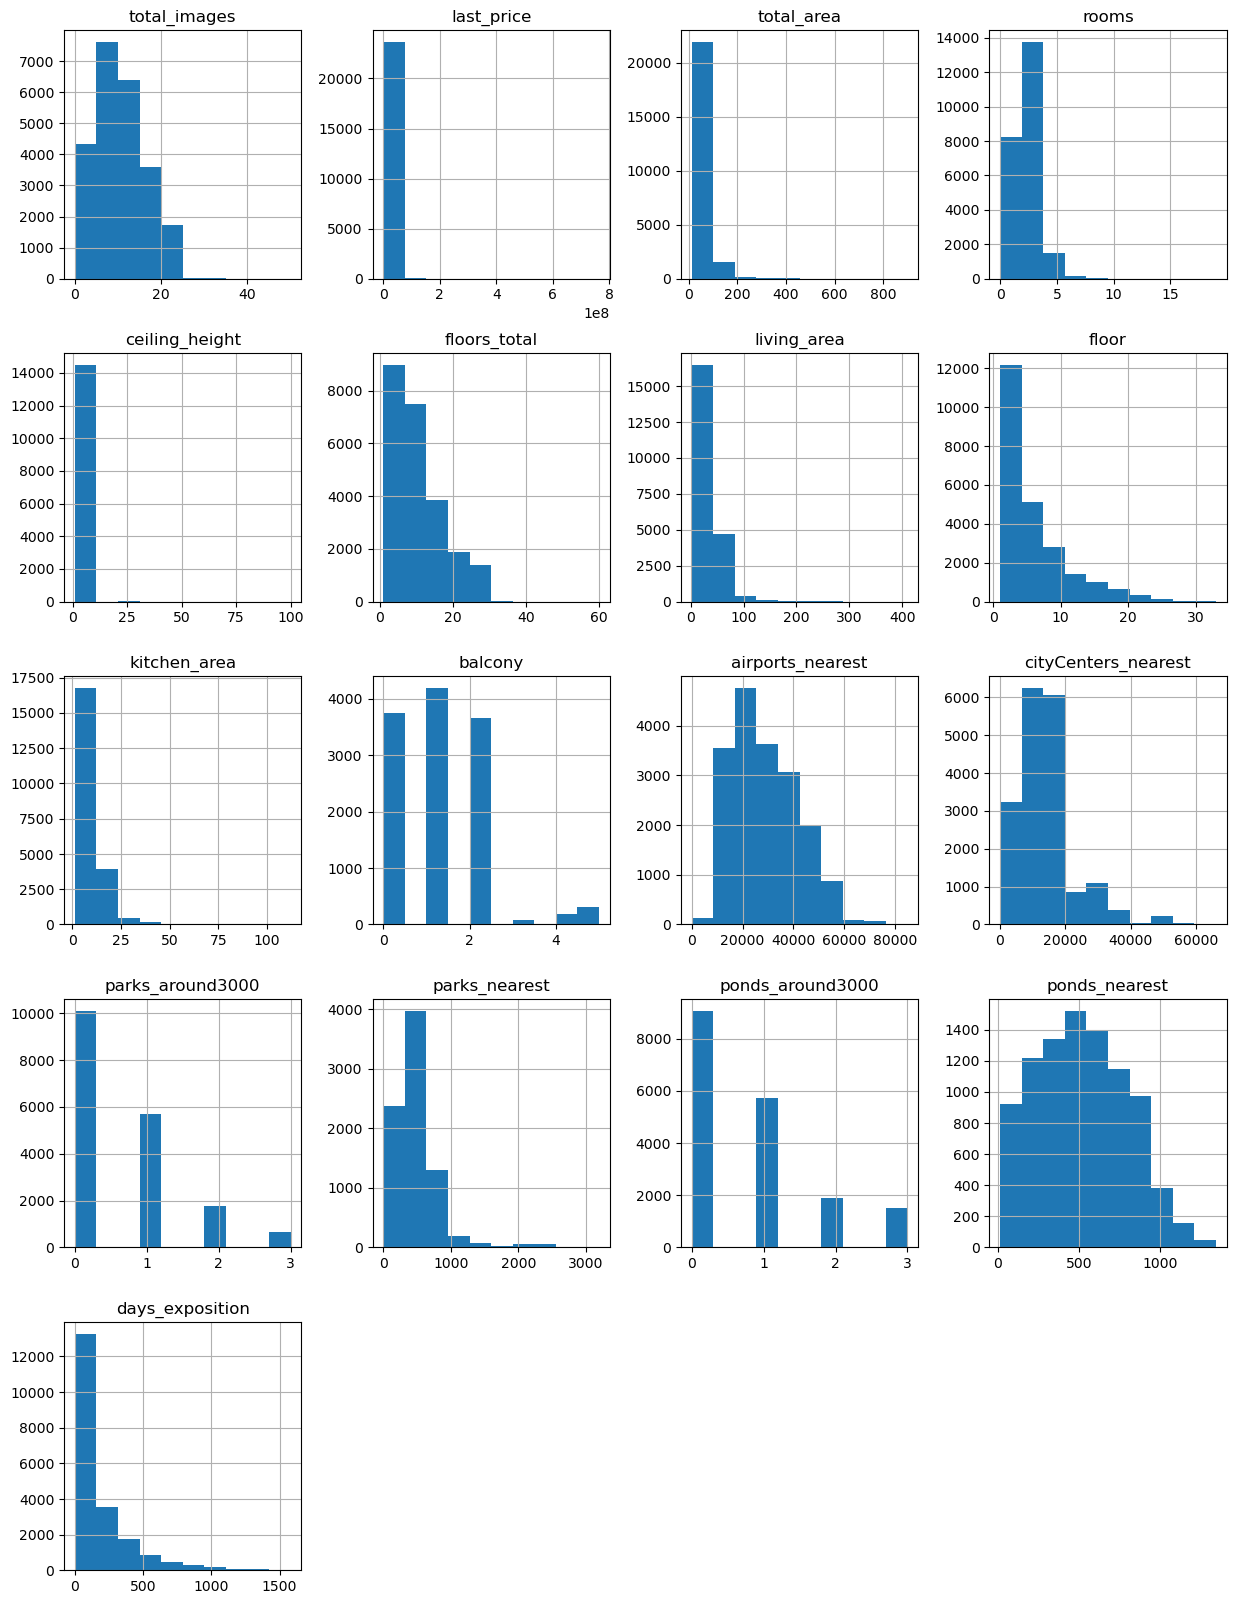

In [8]:
data.hist(figsize=(15, 20));

По внешнему виду гистограмм можем сделать вывод о том, что в данных много аномальных выбросов. Будем с ними разбираться.

### 2 Предобработка данных

Проверим количество пропущенных значений для каждого столбца.

In [9]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Видим, что при общем количествв **23699** строк, пропуски не во всех, а только следующих столбцах:
* ceiling_height - **9195** пропусков. Высота потолков. **Можно пропуски заменить на самое стандартное занчение - 2.70 метра**.
* floors_total - **86** пропусков. Количество этажей в доме. *Не сможем заменить пропуски*. 
* living_area - **1903** пропусков. Жилая площадь в квадратных метрах (м²). *Не сможем заменить пропуски*. 
* is_apartment - **20294** пропусков. Апартаменты (булев тип). **Такой вид жилья появился недавно, поэтому пропуски можно заменить на False**
* kitchen_area - **2278** пропусков. Площадь кухни в квадратных метрах (м²). *Не сможем заменить пропуски*. 
* balcony - **11519** пропусков. Количество балконов. Если неуказано, видимо из просто нет. **Пропуски заменим на 0**
* locality_name - **49** пропусков. Название населённого пункта.  *Не сможем заменить пропуски*. 
* airports_nearest - **5542** пропусков. Расстояние до ближайшего аэропорта в метрах (м). *Не сможем заменить пропуски*. 
* cityCenters_nearest - **5519** пропусков. Расстояние до центра города (м). *Не сможем заменить пропуски*. 
* parks_around3000 - **5518** пропусков. Число парков в радиусе 3 км. *Не сможем заменить пропуски*. 
* parks_nearest - **15620** пропусков. Расстояние до ближайшего парка (м). *Не сможем заменить пропуски*. 
* ponds_around3000 - **5518** пропусков. Число водоёмов в радиусе 3 км. *Не сможем заменить пропуски*. 
* ponds_nearest - **14589** пропусков. Расстояние до ближайшего водоёма (м). *Не сможем заменить пропуски*. 
* days_exposition - **3181** пропусков. Сколько дней было размещено объявление (от публикации до снятия). *Не сможем заменить*. 

**Разберемся со значением "апартаменты".**

Видим, что колонка 'is_apartment' является типом object, хотя согласно Задания должна быть типа bool.

Проверим, какие значения в ней содержатся:

In [10]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

Видим, что все правильно, значения True и False. Поэтому заменим тип данных в колонке **is_apartment** на **bool**:

Такой вид жилья, как апартаменты (не предусматривающий права на прописку), появился совсем недавно. 
И пропуски, возможно, связаны с тем, что не все продавцы указывали, что жилье - квартиры. Пропуски заменим на **False**.

In [11]:
data['is_apartment'] = data['is_apartment'].astype('bool').fillna(False)

**Разберемся с пропусками в количестве балконов**. 

Отсутствие информации наиболее вероятно, связано с отсутствием балкона. 
Таким образом, меняем пропуски информации о количестве балконов на их отсутствие, т.е. **0** и сразу меняем тип данных на int:

In [12]:
data['balcony'] = data['balcony'].fillna(0).astype('int')

И убедимся, что пропущенных значений в **ceiling_height**, **is_apartment** и в **balcony** больше нет:

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  int32  
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Остались пропуски только тех значений, которые мы не можем поменять, исходя их общих представлений об операциях с недвижимостью.

**Разберемся с форматом даты публикации**

Время публикации объявления не указано, да оно и не имеет значения, поэтому приведем значение к формату *Год-Месяц-День*

In [14]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d')

In [15]:
data['first_day_exposition']

0       2019-03-07
1       2018-12-04
2       2015-08-20
3       2015-07-24
4       2018-06-19
           ...    
23694   2017-03-21
23695   2018-01-15
23696   2018-02-11
23697   2017-03-28
23698   2017-07-21
Name: first_day_exposition, Length: 23699, dtype: datetime64[ns]

**Откорректируем оставшиеся столбцы по типу данных**.

**Изучим значения количества этажей в доме**

In [16]:
data['floors_total'].unique()

array([16., 11.,  5., 14., 12., 26., 24., 27.,  9.,  6., 17., 25.,  3.,
       23., 19., 18.,  4., 22.,  8.,  2., 10.,  7., 13., 15., nan, 20.,
       28., 36., 21., 35., 34., 60.,  1., 29., 33., 52., 37.])

In [17]:
data[data['floors_total'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000.0,65.2,2018-10-02,2,NaN,NaN,30.80,4,True,False,False,12.00,0,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
237,4,2438033.0,28.1,2016-11-23,1,NaN,NaN,20.75,1,True,False,False,NaN,0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
457,4,9788348.0,70.8,2015-08-01,2,NaN,NaN,38.40,12,True,False,False,10.63,0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
671,4,6051191.0,93.6,2017-04-06,3,NaN,NaN,47.10,8,True,False,False,16.80,0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123.0
1757,5,3600000.0,39.0,2017-04-22,1,NaN,NaN,NaN,9,True,False,False,NaN,0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22542,5,8500000.0,63.5,2017-05-24,2,2.8,NaN,NaN,3,True,False,False,NaN,0,Санкт-Петербург,51340.0,15363.0,0.0,NaN,1.0,853.0,512.0
22656,4,4574160.0,64.5,2017-04-02,2,NaN,NaN,31.70,20,True,False,False,14.40,0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,127.0
22808,0,14569263.0,110.4,2016-11-20,3,NaN,NaN,45.38,6,True,False,False,23.42,0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,260.0
23590,0,21187872.0,123.3,2017-04-25,3,NaN,NaN,50.40,18,True,False,False,23.60,0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,104.0


86 раз у нас появляется NaN. Пока менять значения количества этажей не будем.

**Изучим значения количества водоемов в радиусе 3 км**

In [18]:
data['ponds_around3000'].unique()

array([ 2.,  0.,  3.,  1., nan])

In [19]:
data[data['ponds_around3000'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5,10,2890000.0,30.40,2018-09-10,1,NaN,12.0,14.40,5,True,False,False,9.10,0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
8,20,2900000.0,33.16,2018-05-23,1,NaN,27.0,15.43,26,True,False,False,8.81,0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
12,10,3890000.0,54.00,2016-06-30,2,NaN,5.0,30.00,5,True,False,False,9.00,0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,90.0
22,20,5000000.0,58.00,2017-04-24,2,2.75,25.0,30.00,15,True,False,False,11.00,2,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,60.0
30,12,2200000.0,32.80,2018-02-19,1,NaN,9.0,NaN,2,True,False,False,NaN,0,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23683,16,2100000.0,62.80,2018-09-18,4,2.50,5.0,45.50,3,True,False,False,5.50,0,посёлок Дзержинского,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23692,2,1350000.0,30.00,2017-07-07,1,NaN,5.0,17.50,4,True,False,False,6.00,0,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0
23695,14,3100000.0,59.00,2018-01-15,3,NaN,5.0,38.00,4,True,False,False,8.50,0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11,2,NaN,3.0,29.70,1,True,False,False,NaN,0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN


5518 раз у нас появляется NaN. Пока менять значения количества прудов не будем.

**Изучим значения количества дней публикации объявления**

In [20]:
data['days_exposition'].unique()

array([  nan,   81.,  558., ..., 1360., 1007.,  971.])

In [21]:
data[data['days_exposition'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.0,8,True,False,False,25.00,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
7,5,7915000.0,71.60,2019-04-18,2,NaN,24.0,NaN,22,True,False,False,18.90,2,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
44,13,5350000.0,40.00,2018-11-18,1,NaN,22.0,NaN,3,True,False,False,NaN,1,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN
45,17,5200000.0,50.60,2018-12-02,2,2.65,9.0,30.3,7,True,False,False,7.00,0,Санкт-Петербург,30011.0,12872.0,0.0,NaN,0.0,NaN,NaN
46,17,6600000.0,52.10,2019-01-31,2,2.60,24.0,29.7,9,True,False,False,8.30,2,Санкт-Петербург,15114.0,12702.0,0.0,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23684,20,21400000.0,145.00,2018-11-02,4,3.00,26.0,71.4,17,True,False,False,15.60,0,Санкт-Петербург,11827.0,11459.0,0.0,NaN,0.0,NaN,NaN
23685,15,2490000.0,31.00,2019-01-24,1,2.50,5.0,17.3,5,True,False,False,5.60,1,Ломоносов,48393.0,51818.0,0.0,NaN,0.0,NaN,NaN
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5.0,73.3,3,True,False,False,13.83,0,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23696,18,2500000.0,56.70,2018-02-11,2,NaN,3.0,29.7,1,True,False,False,NaN,0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN


3181 раз у нас появляется NaN. Пока менять значения количества дней публикации объявления не будем.

**Разберемся с названими населенного пункта**

Из метода data.info() видно, что из общего количества в 23 699 записей названия населенных пунктов есть в 23 650 случаях.
А всего в 49 записей эти данные отсутствуют. 
Ввиду их малочисленности и важности этого значения, удалим записи с пропущенными названиями населенных пунктов:

In [22]:
data = data.dropna(subset=['locality_name'])

In [23]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Посмотрим количество уникальных значений наседенных пунктов:

In [24]:
len(data['locality_name'].unique())

364

Наиболее часто дубликаты происходят из-за слов пос**ё**лок и пос**е**лок. 
Приведем их все к одному виду - **посёлок**.

In [25]:
def correct_poselok_name(str_input):
    if 'поселок' in str_input:
        words = str_input.split()
        temp_list = []
        for word in words:
            if word == 'поселок':
                word = 'посёлок'
            temp_list.append(word)
        aaa = ' '.join(temp_list)
        return str(aaa)

names =['поселок городского типа Токсово', 'поселок городского типа Красный Бор',
        'поселок городского типа Лебяжье', 'поселок городского типа Кузьмоловский',
        'поселок городского типа имени Свердлова', 'поселок городского типа Форносово',
        'поселок городского типа Рощино',   'поселок городского типа Рябово',
        'городской посёлок Янино-1',
        
        'поселок Мурино', 'поселок Аннино', 'поселок Новый Свет', 'поселок Бугры', 'поселок Победа',
        'поселок Терволово', 'поселок Петровское', 'поселок Тельмана', 'поселок Поляны', 'поселок Мичуринское', 
        'поселок Ильичёво', 'поселок Гаврилово', 'поселок Старая Малукса', 'поселок Сапёрный', 
        'поселок Кобралово', 'поселок Мельниково', 'поселок Усть-Луга', 'поселок Жилгородок',
        'поселок Стеклянный', 'поселок Сумино', 'поселок Возрождение', 'поселок Лисий Нос',
        'поселок Пансионат Зелёный Бор', 'поселок Коробицыно', 'поселок Перово', 'поселок Романовка',
       ]

for num in names:
    data = data.replace(num, correct_poselok_name(num))

Избавимся и от дублирования более редких названий:

In [26]:
names ={'деревня Калитино': 'посёлок Калитино', 'деревня Гарболово': 'посёлок Гарболово', 
        'деревня Щеглово': 'посёлок Щеглово', 'деревня Рабитицы': 'посёлок Рабитицы', 
        'деревня Зимитицы': 'посёлок Зимитицы', 'деревня Пчевжа': 'посёлок Пчевжа', 
        'посёлок при железнодорожной станции Вещево': 'посёлок станции Вещево',
        'посёлок при железнодорожной станции Приветнинское': 'посёлок станции Приветнинское',
        'городской посёлок Рощино': 'посёлок городского типа Рощино',
        'поселок Рябово': 'посёлок городского типа Рябово',
        'садовое товарищество Приладожский': 'поселок городского типа Приладожский',
        'посёлок станции Громово': 'поселок Громово',
        'поселок Лесное': 'коттеджный посёлок Лесное',
        'посёлок станции Свирь': 'городской посёлок Свирьстрой',
        'Любань': 'поселок Любань', 'Кудрово': 'деревня Кудрово' 
        }

for key, value in names.items():
    data = data.replace(key, value)

Проверим количество уникальных значений наседенных пунктов после обработки:
(До обработки дубликатов названий населенных пунктов их было 364.

In [27]:
len(data['locality_name'].unique())

323

**Разберемся со значением высоты потолков.** 

Прежде чем заменять пропущенные значения на 2.7 метра, проверим среднее и медианное значения для существующих значений.

In [28]:
print(data['ceiling_height'].mean())
print(data['ceiling_height'].median())

2.7712870945479087
2.65


Видим, что они очень близки к намеченному нами значению в 2.7 метра. Поэтому смело меняем все пропуски на **2.7** 

In [29]:
data['ceiling_height'] = data['ceiling_height'].fillna(2.7)

Проверим, что у нас записано в значениях высоты потолка

In [30]:
data['ceiling_height'].unique()

array([  2.7 ,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,   2.6 ,
         2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,   3.25,
         3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,   3.3 ,
         2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,   3.4 ,
         3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,   2.58,
         3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,   2.45,
         3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,   3.16,
         3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,   5.  ,
         2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,   2.83,
         4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,   3.18,
         3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,   2.63,
         3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,   3.66,
         3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,   3.36,
        32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,   3.26,
      

In [31]:
print(data['ceiling_height'].max())
print(data['ceiling_height'].min())

100.0
1.0


Видим, что есть как аномально низкие (вплоть до 1 метра), так и аномально высокие (100 метров) значения высоты потолка.
Кроме этого, есть несколько значений в диапазоне примерно от 20 до 35 метров. По всей видимости, здесь есть ошибка с положением десятичной точки. Такие значения разделим на 10 и сохраним, а все, что ниже 2 метров и выше 6 - удалим.

In [32]:
data.loc[( data.ceiling_height >= 20), 'ceiling_height'] = data.ceiling_height / 10
data = data.query('2 <= ceiling_height < 6')

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23639 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23639 non-null  int64         
 1   last_price            23639 non-null  float64       
 2   total_area            23639 non-null  float64       
 3   first_day_exposition  23639 non-null  datetime64[ns]
 4   rooms                 23639 non-null  int64         
 5   ceiling_height        23639 non-null  float64       
 6   floors_total          23554 non-null  float64       
 7   living_area           21741 non-null  float64       
 8   floor                 23639 non-null  int64         
 9   is_apartment          23639 non-null  bool          
 10  studio                23639 non-null  bool          
 11  open_plan             23639 non-null  bool          
 12  kitchen_area          21372 non-null  float64       
 13  balcony         

In [34]:
print(data['ceiling_height'].max())
print(data['ceiling_height'].min())

5.8
2.0


In [35]:
data['ceiling_height'].unique()

array([2.7 , 3.03, 2.5 , 2.67, 2.56, 3.05, 2.75, 2.6 , 2.9 , 2.8 , 2.55,
       3.  , 2.65, 3.2 , 2.61, 3.25, 3.45, 2.77, 2.85, 2.64, 2.57, 4.15,
       3.5 , 3.3 , 2.71, 4.  , 2.47, 2.73, 2.84, 3.1 , 2.34, 3.4 , 3.06,
       2.72, 2.54, 2.51, 2.78, 2.76, 2.58, 3.7 , 2.52, 5.2 , 2.87, 2.66,
       2.59, 2.  , 2.45, 3.6 , 2.92, 3.11, 3.13, 3.8 , 3.15, 3.55, 3.16,
       3.62, 3.12, 2.53, 2.74, 2.96, 2.46, 5.3 , 5.  , 2.79, 2.95, 4.06,
       2.94, 3.82, 3.54, 3.53, 2.83, 4.7 , 2.4 , 3.38, 3.01, 5.6 , 3.65,
       3.9 , 3.18, 3.35, 2.3 , 3.57, 2.48, 2.62, 2.82, 3.98, 2.63, 3.83,
       3.52, 3.95, 3.75, 2.88, 3.67, 3.87, 3.66, 3.85, 3.86, 4.19, 3.24,
       4.8 , 4.5 , 4.2 , 3.36, 3.08, 3.68, 3.07, 3.37, 3.09, 3.26, 3.34,
       2.81, 3.44, 2.97, 3.14, 4.37, 2.68, 3.22, 3.27, 4.1 , 2.93, 3.46,
       3.47, 3.33, 3.63, 3.32, 2.98, 2.86, 3.17, 4.4 , 3.28, 3.04, 4.45,
       5.5 , 3.84, 3.23, 3.02, 3.21, 3.43, 3.78, 4.3 , 3.39, 2.69, 3.31,
       4.65, 3.56, 2.2 , 3.51, 3.93, 3.42, 2.99, 3.

**Проверим на предмет аномальных значений цену на момент снятия с публикации:**

In [36]:
data['last_price'].describe()

count    2.363900e+04
mean     6.536789e+06
std      1.087410e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.799000e+06
max      7.630000e+08
Name: last_price, dtype: float64

In [37]:
temporal = data.query('last_price > 3e+08')
temporal

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1436,19,330000000.0,190.0,2018-04-04,3,3.5,7.0,95.0,5,True,False,False,40.0,0,Санкт-Петербург,23011.0,1197.0,3.0,519.0,3.0,285.0,233.0
12971,19,763000000.0,400.0,2017-09-30,7,2.7,10.0,250.0,10,True,False,False,NaN,2,Санкт-Петербург,25108.0,3956.0,1.0,530.0,3.0,756.0,33.0
14706,15,401300000.0,401.0,2016-02-20,5,2.7,9.0,204.0,9,False,False,False,24.0,3,Санкт-Петербург,21912.0,2389.0,1.0,545.0,1.0,478.0,393.0
19540,8,420000000.0,900.0,2017-12-06,12,2.8,25.0,409.7,25,True,False,False,112.0,0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0


Таким образом, и цена в 763 млн рублей за квартиру площадью 400 кв метров не кажется ошибочной. В сегменте сверх дорогого жилья есть еще 2 квартиры дороже 400 млн рублей.

Визуализируем, что значит, **редкая и сверхдорогая квартира**:  

In [38]:
data.query('last_price > 1.5e08').sort_values('last_price', ascending = False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
12971,19,763000000.0,400.0,2017-09-30,7,2.70,10.0,250.0,10,True,False,False,NaN,2,Санкт-Петербург,25108.0,3956.0,1.0,530.0,3.0,756.0,33.0
19540,8,420000000.0,900.0,2017-12-06,12,2.80,25.0,409.7,25,True,False,False,112.0,0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0
14706,15,401300000.0,401.0,2016-02-20,5,2.70,9.0,204.0,9,False,False,False,24.0,3,Санкт-Петербург,21912.0,2389.0,1.0,545.0,1.0,478.0,393.0
1436,19,330000000.0,190.0,2018-04-04,3,3.50,7.0,95.0,5,True,False,False,40.0,0,Санкт-Петербург,23011.0,1197.0,3.0,519.0,3.0,285.0,233.0
15651,20,300000000.0,618.0,2017-12-18,7,3.40,7.0,258.0,5,True,False,False,70.0,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,111.0
22831,18,289238400.0,187.5,2019-03-19,2,3.37,6.0,63.7,6,True,False,False,30.2,0,Санкт-Петербург,22494.0,1073.0,3.0,386.0,3.0,188.0,NaN
16461,17,245000000.0,285.7,2017-04-10,6,3.35,7.0,182.8,4,True,False,False,29.8,0,Санкт-Петербург,33143.0,6235.0,3.0,400.0,3.0,140.0,249.0
13749,7,240000000.0,410.0,2017-04-01,6,3.40,7.0,218.0,7,True,False,False,40.0,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,199.0
5893,3,230000000.0,500.0,2017-05-31,6,2.70,7.0,NaN,7,True,False,False,40.0,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,50.0
8900,13,190870000.0,268.0,2016-03-25,3,2.70,8.0,132.0,7,True,False,False,40.0,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,901.0


Из приведенных данных видно, что единичными и сверхдорогими квартирами можно считать с десяток предложений дороже 200 млн рублей. Они представлены в единичном экземпляре.

**Проверим на предмет невероятных значения общей площади квартиры в м²:**

In [39]:
data['total_area'].describe()

count    23639.000000
mean        60.329739
std         35.658430
min         12.000000
25%         40.000000
50%         52.000000
75%         69.725000
max        900.000000
Name: total_area, dtype: float64

Минимум 12 м², видимо, одна комната. Максимум 900 м². Наверное тоже возможно. 'Красиво жить не запретишь'

Расмотрим подробнее уникальные предложения с **квартирами большой площади**:

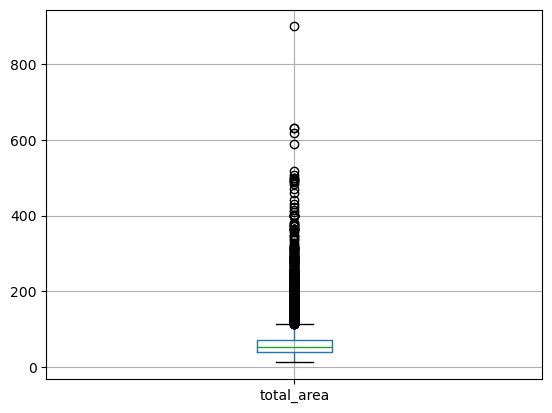

In [40]:
data.boxplot(column='total_area');

Из графика-размаха видно, что уникальные предложения начинаются с величины в 500 м²:

In [41]:
data.query('total_area >= 500').sort_values('total_area', ascending = False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
19540,8,420000000.0,900.0,2017-12-06,12,2.80,25.0,409.7,25,True,False,False,112.0,0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0
12859,20,140000000.0,631.2,2019-04-09,7,3.90,4.0,322.3,4,True,False,False,19.5,1,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN
3117,19,140000000.0,631.0,2019-03-30,7,2.70,5.0,NaN,5,True,False,False,60.0,0,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN
15651,20,300000000.0,618.0,2017-12-18,7,3.40,7.0,258.0,5,True,False,False,70.0,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,111.0
5358,20,65000000.0,590.0,2019-02-14,15,3.50,6.0,409.0,3,True,False,False,100.0,0,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14.0
4237,1,50000000.0,517.0,2017-10-14,7,2.70,4.0,332.0,3,True,False,False,22.0,0,Санкт-Петербург,22835.0,1847.0,2.0,477.0,2.0,540.0,NaN
8018,20,84000000.0,507.0,2015-12-17,5,4.45,7.0,301.5,7,True,False,False,45.5,1,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,NaN,1078.0
5893,3,230000000.0,500.0,2017-05-31,6,2.70,7.0,NaN,7,True,False,False,40.0,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,50.0
15016,8,150000000.0,500.0,2016-01-13,4,3.20,7.0,NaN,7,True,False,False,NaN,0,Санкт-Петербург,33058.0,6150.0,3.0,209.0,3.0,531.0,303.0


Видно, что на рынке есть квартиры площадью 500 - 630 м². Но самых уникальным является предложение № 19540 с квартирой в 900 м². 

**Проверим количество комнат на предмет аномальных значений:**

In [42]:
data['rooms'].describe()

count    23639.000000
mean         2.070223
std          1.078669
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

In [43]:
data['rooms'].unique()

array([ 3,  1,  2,  4,  5,  6,  0,  7, 11,  8, 14, 10, 15,  9, 19, 16, 12],
      dtype=int64)

Количество комнат от 0 до 19. Медиана на уровне 2 комнаты. 
Отклонений от здравого смысла не видим. 0 - может быть для комнат, 19 - для загородного дома.

Посмотрим повнимательнее, сколько в продаже было **уникальных квартир с большим количеством комнат**:

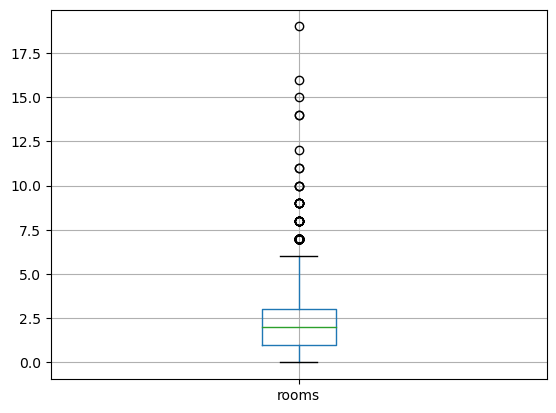

In [44]:
data.boxplot(column='rooms');

По графику размаха видим, что отклонения - это кваритры с количеством комнат 7+. 

Найдем из них поистине редкие экземпляры:

In [45]:
data.query('rooms >= 10').sort_values('rooms', ascending = False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
14498,6,32250000.0,374.6,2018-06-09,19,2.70,5.0,264.5,2,True,False,False,27.6,0,Санкт-Петербург,19497.0,3574.0,0.0,NaN,2.0,548.0,114.0
18848,6,28500000.0,270.0,2015-03-02,16,3.00,4.0,180.0,4,True,False,False,13.0,1,Санкт-Петербург,23575.0,4142.0,1.0,516.0,0.0,NaN,1365.0
5358,20,65000000.0,590.0,2019-02-14,15,3.50,6.0,409.0,3,True,False,False,100.0,0,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14.0
866,5,25000000.0,363.0,2017-12-23,14,3.16,5.0,222.0,4,True,False,False,16.6,0,Санкт-Петербург,38076.0,7950.0,0.0,NaN,2.0,435.0,418.0
20829,6,28659000.0,245.4,2016-03-31,14,2.70,4.0,168.3,2,True,False,False,25.9,0,Санкт-Петербург,21104.0,2054.0,3.0,541.0,2.0,118.0,95.0
19540,8,420000000.0,900.0,2017-12-06,12,2.80,25.0,409.7,25,True,False,False,112.0,0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0
648,3,17500000.0,183.7,2018-07-01,11,3.40,7.0,138.8,7,True,False,False,13.3,0,Санкт-Петербург,23606.0,3148.0,0.0,NaN,0.0,NaN,NaN
9688,8,33000000.0,194.1,2017-02-07,11,3.43,5.0,129.0,2,True,False,False,11.9,0,Санкт-Петербург,21469.0,1015.0,1.0,686.0,2.0,66.0,813.0
4149,6,23000000.0,272.6,2018-01-11,10,3.14,7.0,145.9,7,True,False,False,18.8,1,Санкт-Петербург,10726.0,12169.0,1.0,191.0,1.0,531.0,NaN
18119,4,15500000.0,216.1,2016-07-04,10,3.15,5.0,161.4,2,True,False,False,19.8,0,Санкт-Петербург,24353.0,4921.0,1.0,368.0,0.0,NaN,11.0


Таким образом, в продаже были уникальные предложения с квартирами по 11, 12, 14, 15, 16 и 19 комнат!+

Какой же большой должна быть бригада уборщиц! 

**Посмотрим значения количества этажей в доме:**

In [46]:
data['floors_total'].describe()

count    23554.000000
mean        10.675129
std          6.593221
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

Диапазон от 1 до 60. Медиана на значении в 9 этажей. 60 может быть реальным для небоскреба.

**Проверим значение жилой площади:**

In [47]:
data['living_area'].describe()

count    21741.000000
mean        34.447810
std         22.028146
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

Изучим область максимальных значений:

In [48]:
temporal = data.query('living_area > 300')
temporal

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
660,3,49950000.0,483.9,2017-10-04,7,3.20,6.0,312.5,4,True,False,False,26.4,0,Санкт-Петербург,23079.0,945.0,3.0,461.0,3.0,22.0,391.0
4237,1,50000000.0,517.0,2017-10-14,7,2.70,4.0,332.0,3,True,False,False,22.0,0,Санкт-Петербург,22835.0,1847.0,2.0,477.0,2.0,540.0,NaN
5358,20,65000000.0,590.0,2019-02-14,15,3.50,6.0,409.0,3,True,False,False,100.0,0,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14.0
8018,20,84000000.0,507.0,2015-12-17,5,4.45,7.0,301.5,7,True,False,False,45.5,1,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,NaN,1078.0
12401,20,91500000.0,495.0,2017-06-19,7,4.65,7.0,347.5,7,True,False,False,25.0,0,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,NaN,14.0
12859,20,140000000.0,631.2,2019-04-09,7,3.90,4.0,322.3,4,True,False,False,19.5,1,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN
19540,8,420000000.0,900.0,2017-12-06,12,2.80,25.0,409.7,25,True,False,False,112.0,0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0


Ничего подозрительного не находим. Жилая площадь меньше общей площади.

Изучим область минимальных значений:

In [49]:
temporal = data.query('living_area < 5')
temporal

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3242,7,4440000.0,41.0,2017-07-02,1,2.7,17.0,3.0,17,True,False,False,11.0,0,Санкт-Петербург,19272.0,13073.0,0.0,NaN,0.0,NaN,216.0
13915,20,6350000.0,52.0,2018-02-06,2,3.0,6.0,2.0,2,True,False,False,9.0,0,Санкт-Петербург,32453.0,6521.0,0.0,NaN,1.0,1012.0,91.0
21758,0,2330000.0,23.0,2018-01-01,0,2.7,24.0,2.0,22,True,True,False,NaN,0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,66.0
23574,14,64990000.0,139.0,2015-11-24,3,3.0,8.0,3.0,8,True,False,False,16.0,1,Санкт-Петербург,33255.0,5975.0,1.0,630.0,3.0,100.0,280.0


Как это ни кажется удивительным, не думаю, что значения в 2-3 м² содержат явную ошибку. В бизнесе по продаже недвижимости жуликов много.
Это уже покупателям надо смотреть внимательно!

**Посмотрим значение этажности недвижимости, выставлнной на продажу:**

In [50]:
data['floor'].describe()

count    23639.000000
mean         5.893312
std          4.883450
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

От 1 до 33. Ничего катастрофического нет

**Изучим значение размера кухни:**

In [51]:
data['kitchen_area'].describe()

count    21372.000000
mean        10.566976
std          5.902662
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

Тоже без неожиданностей.

**Изучим значение расстояния до аэропорта:**

In [52]:
data['airports_nearest'].describe()

count    18107.000000
mean     28804.552107
std      12638.938760
min          0.000000
25%      18575.500000
50%      26756.000000
75%      37310.000000
max      84869.000000
Name: airports_nearest, dtype: float64

In [53]:
temporal = data.query('airports_nearest < 6000')
temporal

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
21085,0,7000000.0,34.7,2018-09-23,1,2.7,9.0,19.8,3,True,False,False,6.0,2,Санкт-Петербург,0.0,22801.0,0.0,NaN,0.0,NaN,60.0


Ближе 6 км от аэропорта только ОДНА квартира. Оставим ее.

**Посмотрим значение расстояния до центра города:**

In [54]:
data['cityCenters_nearest'].describe()

count    18130.000000
mean     14198.071760
std       8607.789593
min        181.000000
25%       9241.000000
50%      13106.000000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

Все разумно!

**Посмотрим количество парков в радиусе 3 км от продаваемого жилья:**

In [55]:
data['parks_around3000'].describe()

count    18131.000000
mean         0.611384
std          0.801812
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: parks_around3000, dtype: float64

От 0 до 3. Без аномалий!

**Посмотрим расстояние до ближайшего парка:**

In [56]:
data['parks_nearest'].describe()

count    8059.000000
mean      490.866857
std       342.630330
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

Все нормально.

**Посмотрим количество водоемов в радиусе 3 км:**

In [57]:
data['ponds_around3000'].describe()

count    18131.000000
mean         0.769400
std          0.937744
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: ponds_around3000, dtype: float64

Логично.

**Посмотрим расстояние до ближайшего водоема:**

In [58]:
data['ponds_nearest'].describe()

count    9079.000000
mean      518.207622
std       277.826145
min        13.000000
25%       294.000000
50%       503.000000
75%       730.000000
max      1344.000000
Name: ponds_nearest, dtype: float64

Отлично!

**И последний параметр - количество дней с публикации объявления о продаже:**

In [59]:
data['days_exposition'].describe()

count    20459.000000
mean       180.745638
std        219.803970
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

Тоже без аномалий!

**В итоге, у нас получились следующие данные:**

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23639 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23639 non-null  int64         
 1   last_price            23639 non-null  float64       
 2   total_area            23639 non-null  float64       
 3   first_day_exposition  23639 non-null  datetime64[ns]
 4   rooms                 23639 non-null  int64         
 5   ceiling_height        23639 non-null  float64       
 6   floors_total          23554 non-null  float64       
 7   living_area           21741 non-null  float64       
 8   floor                 23639 non-null  int64         
 9   is_apartment          23639 non-null  bool          
 10  studio                23639 non-null  bool          
 11  open_plan             23639 non-null  bool          
 12  kitchen_area          21372 non-null  float64       
 13  balcony         

**Проверим, насколько у нас уменьшилась таблица**:

In [61]:
data.shape

(23639, 22)

Таким образом, видим, что после всех манипуляций по предобработке данных у нас осталось 23 639 строк, 
а в файле с исходными данными их было 23 699, т.е, потери составили:

In [62]:
print(f'Абсолютное значение отброшенных данных составляет: {23699 - data.shape[0]} строк.')
print(f'В процентном соотношении это не превышает: {1 - data.shape[0]/23699 :.2%}')

Абсолютное значение отброшенных данных составляет: 60 строк.
В процентном соотношении это не превышает: 0.25%


Таким образом, с таким количеством утерянных данных можем согласится.

### 3 Посчитайте и добавьте в таблицу новые столбцы

**3.1 Добавим в таблицу столбец со стоимостью одного квадратного метра:**

In [63]:
data['price_square_meter'] = data['last_price'] / data['total_area']

**3.2 Добавим колонку с днём недели публикации объявления (0 — понедельник, 1 — вторник и так далее):**

In [64]:
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday

**3.3 Добавим столбец со значением месяца публикации объявления:**

In [65]:
data['month_exposition'] = data['first_day_exposition'].dt.month

**3.4 Добавим год публикации объявления:**

In [66]:
data['year_exposition'] = data['first_day_exposition'].dt.year

**3.5 Введем колонку тип этажа квартиры (значения — «первый», «последний», «другой»):**

Создадим функцию *floor_category* для категоризации квартир по этажам, выделяя из них первый и последний.

In [67]:
def floor_category(row):
    floor_current = row['floor']
    floors_total = row['floors_total']
    if floor_current == 1:
        return 'первый'
    elif floor_current == floors_total:
        return 'последний'
    elif 1 < floor_current < floors_total:
        return 'другой'

In [68]:
data['floor_category'] = data.apply(floor_category, axis = 1)

**3.6 Добавим столбец с расстоянием до центра города в километрах (пересчитаем из м в км):**

In [69]:
data['cityCenter_dist_km'] = data['cityCenters_nearest'] // 1000

**Посмотрим, что получилось с вновь добавленными колонками:**

In [70]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category,cityCenter_dist_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,True,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370,3,3,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.70,11.0,18.6,1,True,False,False,11.0,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,первый,18.0
2,10,5196000.0,56.0,2015-08-20,2,2.70,5.0,34.3,4,True,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,другой,13.0
3,0,64900000.0,159.0,2015-07-24,3,2.70,14.0,NaN,9,True,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.100629,4,7,2015,другой,6.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,True,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000,1,6,2018,другой,8.0


In [71]:
data['price_square_meter'] = data['price_square_meter'].astype('int')

In [72]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category,cityCenter_dist_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,True,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370,3,3,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.70,11.0,18.6,1,True,False,False,11.0,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920,1,12,2018,первый,18.0
2,10,5196000.0,56.0,2015-08-20,2,2.70,5.0,34.3,4,True,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785,3,8,2015,другой,13.0
3,0,64900000.0,159.0,2015-07-24,3,2.70,14.0,NaN,9,True,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176,4,7,2015,другой,6.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,True,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000,1,6,2018,другой,8.0


Теперь с добавленными столбцами все в порядке.

### 4 Проведите исследовательский анализ данных

4.1 **Изучим параметр ОБЩАЯ ПЛОЩАДЬ**

In [73]:
data['total_area'].describe()

count    23639.000000
mean        60.329739
std         35.658430
min         12.000000
25%         40.000000
50%         52.000000
75%         69.725000
max        900.000000
Name: total_area, dtype: float64

In [74]:
temporal = data.query('total_area >= 900')
temporal

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category,cityCenter_dist_km
19540,8,420000000.0,900.0,2017-12-06,12,2.8,25.0,409.7,25,True,False,False,112.0,0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0,466666,2,12,2017,последний,7.0


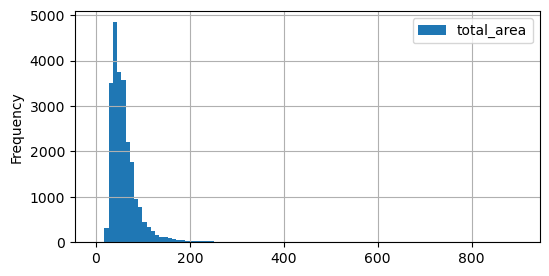

In [75]:
data.plot(y = 'total_area', kind = 'hist', bins = 100, grid=True, figsize = (6,3), range = (0,900));

Можем констатировать, что для продажи выставлено жилье с большим диапазоном по размеру общей площади. Размах составляет от 12 м² (возможно 1 комната или мини студия) до огромных 900 м² с 12 комнатами! Медианное значение на рынке  составляет около 52 м². Распределение квартир на общей площади близко к нормальному.

4.2 **Рассмотрим параметр ЖИЛАЯ ПЛОЩАДЬ**

In [76]:
data['living_area'].describe()

count    21741.000000
mean        34.447810
std         22.028146
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

In [77]:
temporal = data.query('living_area >= 300')
temporal

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category,cityCenter_dist_km
660,3,49950000.0,483.9,2017-10-04,7,3.20,6.0,312.5,4,True,False,False,26.4,0,Санкт-Петербург,23079.0,945.0,3.0,461.0,3.0,22.0,391.0,103223,2,10,2017,другой,0.0
4237,1,50000000.0,517.0,2017-10-14,7,2.70,4.0,332.0,3,True,False,False,22.0,0,Санкт-Петербург,22835.0,1847.0,2.0,477.0,2.0,540.0,NaN,96711,5,10,2017,другой,1.0
5358,20,65000000.0,590.0,2019-02-14,15,3.50,6.0,409.0,3,True,False,False,100.0,0,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14.0,110169,3,2,2019,другой,4.0
8018,20,84000000.0,507.0,2015-12-17,5,4.45,7.0,301.5,7,True,False,False,45.5,1,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,NaN,1078.0,165680,3,12,2015,последний,5.0
12401,20,91500000.0,495.0,2017-06-19,7,4.65,7.0,347.5,7,True,False,False,25.0,0,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,NaN,14.0,184848,0,6,2017,последний,5.0
12859,20,140000000.0,631.2,2019-04-09,7,3.90,4.0,322.3,4,True,False,False,19.5,1,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN,221799,1,4,2019,последний,4.0
14088,8,51000000.0,402.0,2017-02-07,6,3.15,8.0,300.0,6,True,False,False,56.0,2,Санкт-Петербург,24484.0,5052.0,1.0,253.0,0.0,NaN,32.0,126865,1,2,2017,другой,5.0
19540,8,420000000.0,900.0,2017-12-06,12,2.80,25.0,409.7,25,True,False,False,112.0,0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0,466666,2,12,2017,последний,7.0


В области больших размеров жилой площади квартир ничего паранормального не выявлено. Все эти значения меньше размеров общей площади жилья и стоят, соответственно, дорого.

In [78]:
temporal = data.query('living_area <= 6')
temporal

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category,cityCenter_dist_km
3242,7,4440000.0,41.0,2017-07-02,1,2.7,17.0,3.0,17,True,False,False,11.0,0,Санкт-Петербург,19272.0,13073.0,0.0,NaN,0.0,NaN,216.0,108292,6,7,2017,последний,13.0
13915,20,6350000.0,52.0,2018-02-06,2,3.0,6.0,2.0,2,True,False,False,9.0,0,Санкт-Петербург,32453.0,6521.0,0.0,NaN,1.0,1012.0,91.0,122115,1,2,2018,другой,6.0
16431,13,3799000.0,31.0,2018-04-12,1,2.6,5.0,6.0,1,True,False,False,17.0,0,Санкт-Петербург,32177.0,4826.0,1.0,430.0,0.0,NaN,168.0,122548,3,4,2018,первый,4.0
17582,11,2680000.0,22.0,2018-08-11,0,2.7,25.0,5.0,8,True,True,False,NaN,2,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,70.0,121818,5,8,2018,другой,11.0
21758,0,2330000.0,23.0,2018-01-01,0,2.7,24.0,2.0,22,True,True,False,NaN,0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,66.0,101304,0,1,2018,другой,NaN
21943,15,6100000.0,77.6,2019-02-28,4,2.5,9.0,5.4,1,True,False,False,9.8,0,Санкт-Петербург,29338.0,11270.0,1.0,584.0,0.0,NaN,33.0,78608,3,2,2019,первый,11.0
23574,14,64990000.0,139.0,2015-11-24,3,3.0,8.0,3.0,8,True,False,False,16.0,1,Санкт-Петербург,33255.0,5975.0,1.0,630.0,3.0,100.0,280.0,467553,1,11,2015,последний,5.0


In [79]:
data['living_area'].corr(data['total_area'])

0.9395252117332423

Наблюдаем очень хорошую корреляцию между значениями жилой площади и общей площади. Таким образом, принципиальных ошибок тут нет.

В области квартир с маленьким размером жилой площади картина интереснее. 
1) Видим наличие предложений на жилье с очень маленькими площадями. Есть даже 4 квартиры со значениями в 2-3 м². Первое предположение об ошибке в 10 раз не подтверждается. Такую гипотезу опровергают предложения:
    - жилая площадь 2 м², а общая 23 м². 
    - жилая площадь 5 м², а общая 22 м². 
    - жилая площадь 6 м², а общая 31 м². 
    Конечно, опечатки возможны, но надо разбираться с каждым случаем отдельно. 
    А в общем случае предложения на жилье в несколько м² вполне реальны. Здесь речь может идти о махинациях с регистрацией, пропиской и т.д.     

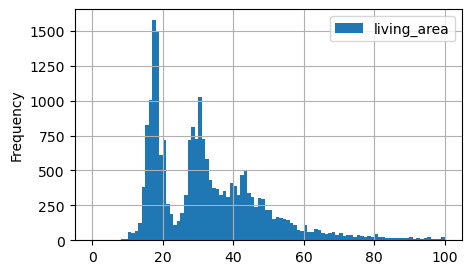

In [80]:
data.plot(y = 'living_area', kind = 'hist', bins = 100, grid=True, figsize = (5,3), range = (0,100));

2) Наблюдаем три ярко выраженных пика на уровне 18, 30 и 45 м². 
   Такому поведению графика есть простое объяснение, так как это наиболее характерные значения размеров жилой площади для 1, 2 и 3-х комнатных квартир соответственно. Таких квартир много в старом жилом фонде.

4.3 **Понаблюдаем за параметром ПЛОЩАДЬ КУХНИ**

In [81]:
data['kitchen_area'].describe()

count    21372.000000
mean        10.566976
std          5.902662
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

Видим, что медианное значение на уровне 9 м², что вполне разумно. Есть и критические значения на уровне 100 м² и менее 5 м². Расмотрим их внимательнее: 

In [82]:
temporal = data.query('kitchen_area > 100')
temporal

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category,cityCenter_dist_km
2489,9,12500000.0,255.0,2017-04-21,3,2.7,2.0,153.9,2,True,False,False,100.7,0,Санкт-Петербург,29544.0,6916.0,0.0,NaN,3.0,198.0,102.0,49019,4,4,2017,последний,6.0
19540,8,420000000.0,900.0,2017-12-06,12,2.8,25.0,409.7,25,True,False,False,112.0,0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0,466666,2,12,2017,последний,7.0
20215,2,85000000.0,249.7,2018-02-01,3,2.7,10.0,72.0,9,True,False,False,107.0,4,Санкт-Петербург,31532.0,4624.0,1.0,2218.0,2.0,99.0,26.0,340408,3,2,2018,другой,4.0


В предложении есть сразу 3 квартиры с кухнями размером более 100 м². Подозрений они не вызывают. Вполне возможно, что это объединенная зона
кухня-столовая.

In [83]:
temporal = data.query('kitchen_area < 3')
temporal

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category,cityCenter_dist_km
906,15,2600000.0,27.00,2017-07-10,1,2.75,23.0,18.0,18,True,False,False,2.00,0,Санкт-Петербург,22131.0,17459.0,0.0,NaN,1.0,411.0,10.0,96296,0,7,2017,другой,17.0
6262,9,3100000.0,24.00,2018-06-25,2,3.00,5.0,16.0,5,True,False,False,2.00,0,Санкт-Петербург,31960.0,4914.0,2.0,426.0,1.0,936.0,54.0,129166,0,6,2018,последний,4.0
7950,3,5967734.0,66.40,2017-02-07,2,2.70,4.0,44.4,2,False,False,False,2.89,0,Санкт-Петербург,44870.0,20802.0,0.0,NaN,0.0,NaN,335.0,89875,1,2,2017,другой,20.0
8729,9,2200000.0,18.40,2018-08-20,1,2.52,3.0,14.0,3,True,False,False,2.40,0,Пушкин,20710.0,30687.0,0.0,NaN,1.0,155.0,59.0,119565,0,8,2018,последний,30.0
9138,17,2920000.0,23.29,2018-12-12,1,2.70,3.0,21.0,1,True,False,False,2.00,0,Санкт-Петербург,19506.0,4008.0,0.0,NaN,2.0,45.0,107.0,125375,2,12,2018,первый,4.0
11033,6,5350000.0,32.00,2016-04-20,1,2.70,14.0,16.0,10,True,False,False,2.00,0,Санкт-Петербург,19008.0,3953.0,0.0,NaN,1.0,69.0,210.0,167187,2,4,2016,другой,3.0
16367,2,2720000.0,25.70,2017-10-30,1,2.70,19.0,22.6,11,True,False,False,2.00,0,Санкт-Петербург,14472.0,13268.0,0.0,NaN,0.0,NaN,109.0,105836,0,10,2017,другой,13.0
17834,5,2940000.0,34.70,2017-10-09,1,2.70,26.0,15.5,14,True,False,False,2.30,1,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,318.0,84726,0,10,2017,другой,NaN
19642,5,1190000.0,14.00,2018-07-29,1,2.70,5.0,11.0,1,True,False,False,2.00,0,Санкт-Петербург,9898.0,11122.0,0.0,NaN,0.0,NaN,4.0,85000,6,7,2018,первый,11.0
20217,7,4250000.0,28.50,2019-05-01,1,2.80,14.0,19.5,10,True,False,False,1.30,0,Санкт-Петербург,37199.0,12721.0,0.0,NaN,0.0,NaN,NaN,149122,2,5,2019,другой,12.0


Интересно, что есть 11 предложений на жилье с площадью кухни менее 3 м². Практически все они "малоемкие" с общей площадью в 20-30 м². Такие квартиры строили в 60-х годах прошлого века.

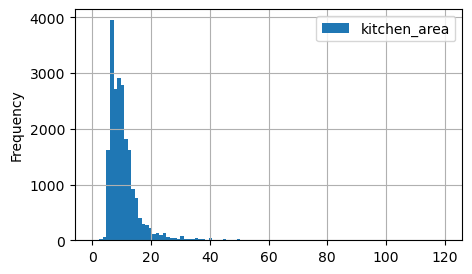

In [84]:
data.plot(y = 'kitchen_area', kind = 'hist', bins = 100, grid=True, figsize = (5,3), range = (0,120));

Распределение по размеру кухни соответствует нормальному распределению.

4.4 **Изучим параметр ЦЕНА ОБЪЕКТА**

In [85]:
data['last_price'].describe()

count    2.363900e+04
mean     6.536789e+06
std      1.087410e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.799000e+06
max      7.630000e+08
Name: last_price, dtype: float64

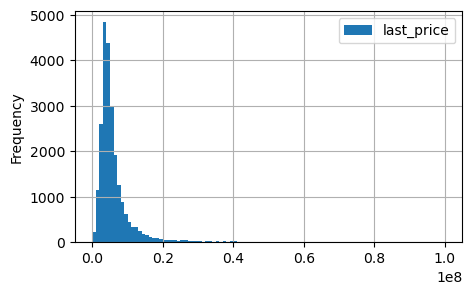

In [86]:
data.plot(y = 'last_price', kind = 'hist', bins = 100, grid=True, range = (0,100000000), figsize = (5,3));

Посмотрим эту картинку в масштабе с миллионами по оси абсцисс:

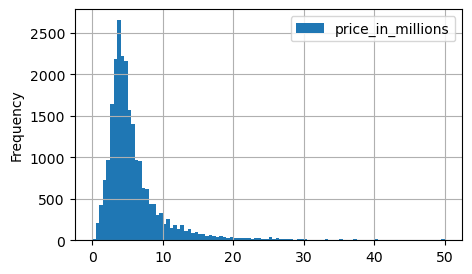

In [87]:
data['price_in_millions'] = data['last_price'] / 1e06
data.plot(y = 'price_in_millions', kind = 'hist', bins = 100, grid=True, range = (0,50), figsize = (5,3));

Здесь нет ничего необычного. Медианное значение на уровне 4,5 млн рублей за квартиру. Минимальное значение около 1.2 тыс рублей (видимо доля в квартире или комната) до 760 млн рублей за огромную современную квартиру.
Распределение цен соответствует нормальному распределению.

4.5 **Посмотрим на параметр КОЛИЧЕСТВО КОМНАТ**

In [88]:
data['rooms'].describe()

count    23639.000000
mean         2.070223
std          1.078669
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

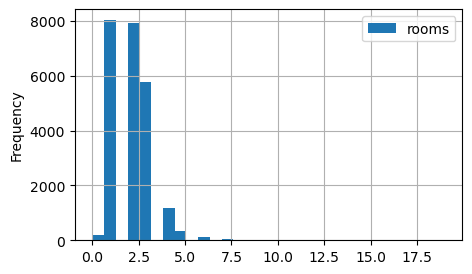

In [89]:
data.plot(y = 'rooms', kind = 'hist', bins = 30, grid=True, figsize = (5,3));

В общем все справедливо. Если квартиры максимум с 19 комнатами. Мединанное значение по рынку - 2 двухкомнатные квартиру. 
В основном - стандартные предложения: однушки, двушки, трешки.
Посмотрим, что такое квартиры без указанного количества комнат:

In [90]:
temporal = data.query('rooms < 1')
temporal

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category,cityCenter_dist_km,price_in_millions
144,1,2450000.0,27.00,2017-03-30,0,2.7,24.0,15.50,2,True,True,False,NaN,2,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,181.0,90740,3,3,2017,другой,NaN,2.450
349,4,2320000.0,25.00,2017-09-27,0,2.7,14.0,17.00,1,True,False,True,NaN,0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,45.0,92800,2,9,2017,первый,NaN,2.320
440,8,2480000.0,27.11,2018-03-12,0,2.7,17.0,24.75,4,True,True,False,NaN,2,Санкт-Петербург,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0,91479,0,3,2018,другой,15.0,2.480
508,0,3375000.0,34.40,2017-03-28,0,2.7,26.0,24.30,19,True,False,True,NaN,1,посёлок Парголово,53115.0,19292.0,0.0,NaN,1.0,593.0,430.0,98110,1,3,2017,другой,19.0,3.375
608,2,1850000.0,25.00,2019-02-20,0,2.7,10.0,NaN,7,True,True,False,NaN,0,посёлок Шушары,NaN,NaN,NaN,NaN,NaN,NaN,29.0,74000,2,2,2019,другой,NaN,1.850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23210,7,3200000.0,26.00,2017-09-01,0,2.7,25.0,18.00,16,True,True,False,NaN,0,Санкт-Петербург,11405.0,13222.0,0.0,NaN,1.0,623.0,14.0,123076,4,9,2017,другой,13.0,3.200
23442,0,2500000.0,27.70,2017-09-28,0,2.7,24.0,18.00,4,True,False,True,NaN,2,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,4.0,90252,3,9,2017,другой,NaN,2.500
23554,15,3350000.0,26.00,2018-09-07,0,2.7,19.0,NaN,8,True,True,False,NaN,0,Санкт-Петербург,18090.0,17092.0,0.0,NaN,2.0,112.0,31.0,128846,4,9,2018,другой,17.0,3.350
23592,10,1450000.0,29.00,2017-11-11,0,2.7,9.0,18.00,8,True,False,True,NaN,2,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,82.0,50000,5,11,2017,другой,NaN,1.450


Все понятно. Видим, что на рынке есть около 200 предложений на квартиры-студии обшей площью около 30 м²

4.6 **Посмотрим на параметр ВЫСОТА ПОТОЛКОВ**

In [91]:
data['ceiling_height'].describe()

count    23639.000000
mean         2.716012
std          0.217277
min          2.000000
25%          2.600000
50%          2.700000
75%          2.700000
max          5.800000
Name: ceiling_height, dtype: float64

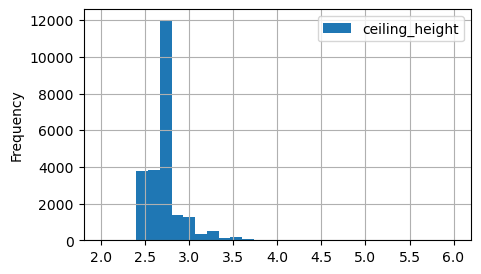

In [92]:
data.plot(y = 'ceiling_height', kind = 'hist', bins = 30, range = (2,6), grid=True, figsize = (5,3));

Тут вообще ничего интересного. В основном высота потолков стандартные 2.7 м.

**4.7 Обратим внимание на параметр ЭТАЖ КВАРТИРЫ**

In [93]:
data['floor'].describe()

count    23639.000000
mean         5.893312
std          4.883450
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

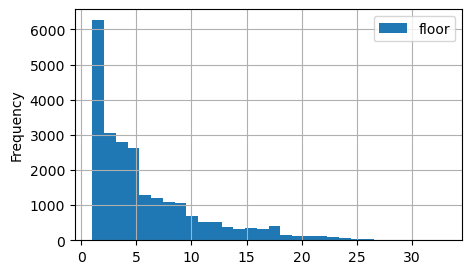

In [94]:
data.plot(y = 'floor', kind = 'hist', bins = 30, range = (1,33), grid=True, figsize = (5,3));

Вполне разумное распределение. доминируют 102 этажные зджания (видимо, частный сектор). Но в последнее время появились и высотные здания.

**4.8 Обратим внимание на категорию этажа квартиры («первый», «последний», «другой»)**

In [95]:
print(len(data[data['floor_category'] == 'первый']))
print(len(data[data['floor_category'] == 'другой']))
print(len(data[data['floor_category'] == 'последний']))

2910
17319
3328


Как видим, на первый и последний этажи приходится чуть менее 10% предложения для каждого. А более 80% на 'срединные' этажи. Их, еcтественно, больше в общем количестве.

**4.9 Посмотрим на параметр ОБЩЕЕ количество этажей в доме**

In [96]:
data['floors_total'].describe()

count    23554.000000
mean        10.675129
std          6.593221
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

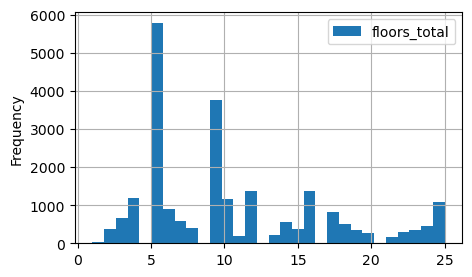

In [97]:
data.plot(y = 'floors_total', kind = 'hist', bins = 30, range = (1,25), grid=True, figsize = (5,3));

Из этого распределения можно сделать следующие выводы:

1) Отсутствуют типовые проекты строительства домов в 4, 8, 13 и 21 этаж.

2) Самыми распространенными являются дома в 5 этажей ("хрущевки"), в 9 - панельные. И в последнее время стали строить дома в 25 этажей.

**4.10 Посмотрим на параметр расстояние до центра города**

In [98]:
data['cityCenter_dist_km'].describe()

count    18130.000000
mean        13.701655
std          8.610507
min          0.000000
25%          9.000000
50%         13.000000
75%         16.000000
max         65.000000
Name: cityCenter_dist_km, dtype: float64

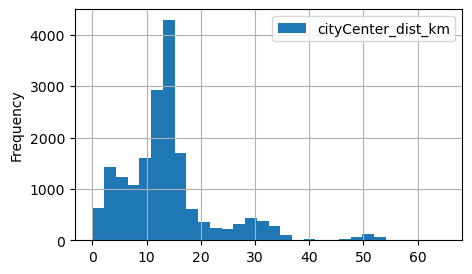

In [99]:
data.plot(y = 'cityCenter_dist_km', kind = 'hist', bins = 30, range = (0,65), grid=True, figsize = (5,3));

Видно, что город распространен на расстояние 17-18 км от центра. На расстоянии в 30 и 50 км есть пополурные пригородны.

In [100]:
data.query('25 < cityCenter_dist_km < 35')['locality_name']

13         Петергоф
14           Пушкин
28           Пушкин
33          Колпино
42         Петергоф
            ...    
23656       Колпино
23667    Сестрорецк
23669       Колпино
23678        Пушкин
23693      Петергоф
Name: locality_name, Length: 1389, dtype: object

Напрнимер, на удалении 25 - 35 км находятся такие известные пригоры Санкт-Петербурга, как Петергоф, Пушкин, Колпино и др.

**4.11 Посмотрим на параметр расстояние до ближайшего аэропорта**

In [101]:
data['airports_nearest'].describe()

count    18107.000000
mean     28804.552107
std      12638.938760
min          0.000000
25%      18575.500000
50%      26756.000000
75%      37310.000000
max      84869.000000
Name: airports_nearest, dtype: float64

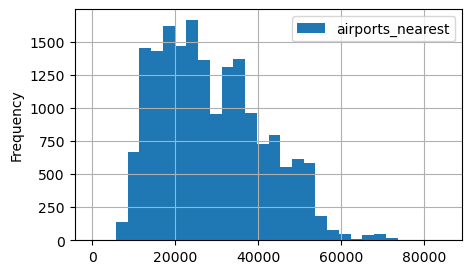

In [102]:
data.plot(y = 'airports_nearest', kind = 'hist', bins = 30, range = (0,85000), grid=True, figsize = (5,3));

Вполне предсказуемая картина. Города расположены на удалении 10 - 60 км от аэропорта.

**4.12 Посмотрим на параметр расстояние до ближайшего парка**

In [103]:
data['parks_nearest'].describe()

count    8059.000000
mean      490.866857
std       342.630330
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

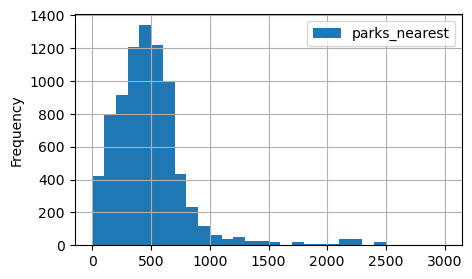

In [104]:
data.plot(y = 'parks_nearest', kind = 'hist', bins = 30, range = (0,3000), grid=True, figsize = (5,3));

Можно сделать о том, что в Санкт-Петербурге и его пригородах очень много парков. В основном жилые дома находятся в пределах 1 км от ближайшего парка.

**4.13 Посмотрим на параметр день и месяц публикации объявления**

In [105]:
data['weekday_exposition'].describe()

count    23639.000000
mean         2.568848
std          1.788856
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: weekday_exposition, dtype: float64

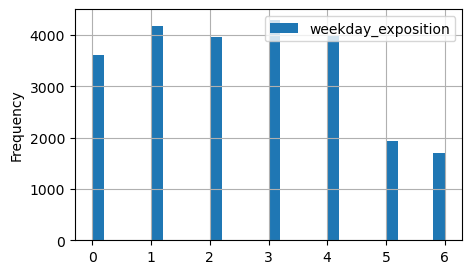

In [106]:
data.plot(y = 'weekday_exposition', kind = 'hist', bins = 30, range = (0,6), grid=True, figsize = (5,3));

Видим, что объявления расмещаются преимущественно в рабочие дни. В выходные такая активность падает.

In [107]:
data['month_exposition'].describe()

count    23639.000000
mean         6.400990
std          3.491786
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month_exposition, dtype: float64

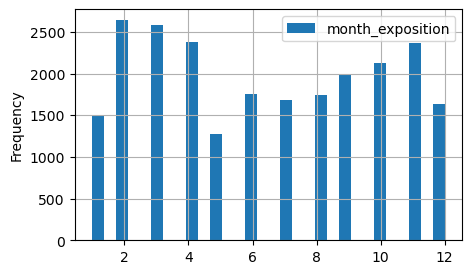

In [108]:
data.plot(y = 'month_exposition', kind = 'hist', bins = 30, range = (1,12), grid=True, figsize = (5,3));

Заметно, что больше подается объявлений о продаже жилья в периоды февраль-апрель и сентябрь-ноябрь. В летние месяцы эта активность чуть уменьшается, как и в районе новогодних каникул.

**4.14 Задание: "Как быстро продавались квартиры (столбец days_exposition)".**

In [109]:
data['days_exposition'].describe()

count    20459.000000
mean       180.745638
std        219.803970
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

Интересно:
- среднее значение находится на уровне 180 дней, 
- медианное значительно меньше, около 95, 
- межквартильный размах - от 45 до 232 дней.

Предположим, что так влияют аномально большие значения. Проверим свою гипотезу и построим **диаграмму размаха**:

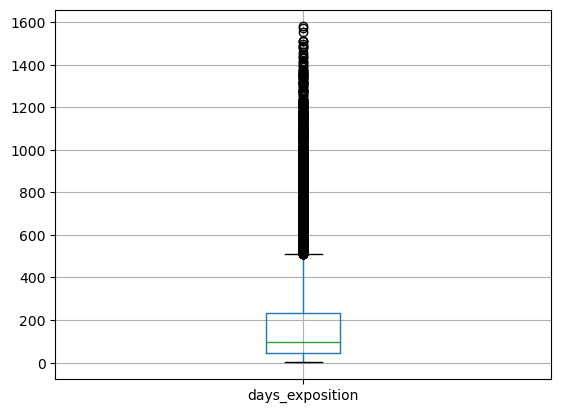

In [110]:
data.boxplot(column='days_exposition');

Диаграмма размаха у нас лежит в диапазоне от минимального значения до примерно 500 дней. А выше этого значения видно большое количество аномалий.

Кроме того, выше установлено, что по методу describe межквартильный размах заканчивался на уровне 232 дня.

По всей видимости, аномально коротких значений у нас нет, а необычно долгих, выше 500 дней, довольно много, а нормальные значения у нас лежат в диапазоне от 1 до 500 дней.

Посмотрим, сколько у нас записей с длительностью более 500 дней:

In [111]:
print(len(data[data['days_exposition'] > 500]))

1744


Довольно много. Не будем их удалять.

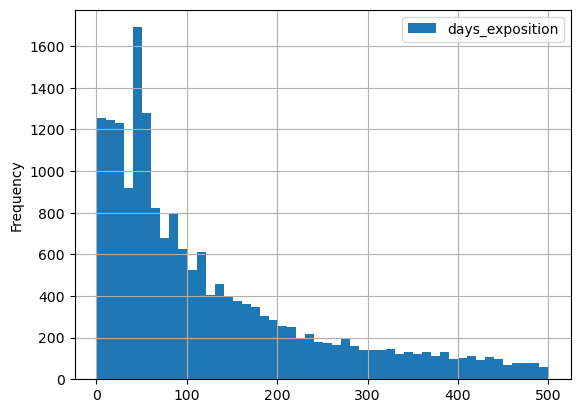

In [112]:
data.plot(y = 'days_exposition', kind = 'hist', bins = 50, grid = True, range = (1, 500));

Распределение по частотам длительности публикации объявления о продаже жилья демонстрирует нормальность его распределения.

Посмотрим количество самых частых значений:

In [113]:
data['days_exposition'].value_counts()

45.0      879
60.0      538
7.0       234
30.0      208
90.0      203
         ... 
1553.0      1
793.0       1
1434.0      1
1231.0      1
971.0       1
Name: days_exposition, Length: 1141, dtype: int64

Странно, у нас есть 5 значений длительности публикаций объявлений о продаже (45, 60, 7, 30 и 90 дней) на которые приходится аномально высокие значения окончания публикаций (от 200 до 900 в день!). Такое ощущение, что объявления принудительно снимали. Почему - непонятно?!

Проверим эту гипотезу при значении 7 дней:

In [114]:
data[data['days_exposition']==7]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category,cityCenter_dist_km,price_in_millions
11,9,3300000.0,44.00,2018-08-27,2,2.70,5.0,31.00,4,False,False,False,6.00,1,Ломоносов,48252.0,51677.0,0.0,NaN,0.0,NaN,7.0,75000,0,8,2018,другой,51.0,3.30
156,11,10990000.0,80.00,2018-06-25,2,2.75,22.0,34.00,19,True,False,False,19.00,2,Санкт-Петербург,34967.0,14640.0,0.0,NaN,1.0,564.0,7.0,137375,0,6,2018,другой,14.0,10.99
301,7,3700000.0,47.00,2018-09-12,2,2.70,9.0,29.00,7,True,False,False,9.00,0,Колпино,25316.0,31102.0,1.0,50.0,0.0,NaN,7.0,78723,2,9,2018,другой,31.0,3.70
332,1,3300000.0,32.90,2018-11-01,1,2.70,12.0,17.90,7,True,False,False,6.20,0,Санкт-Петербург,47694.0,16122.0,0.0,NaN,0.0,NaN,7.0,100303,3,11,2018,другой,16.0,3.30
337,19,5500000.0,55.00,2018-03-06,2,2.70,9.0,31.20,4,True,False,False,8.50,2,Санкт-Петербург,34589.0,12622.0,0.0,NaN,0.0,NaN,7.0,100000,1,3,2018,другой,12.0,5.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23244,15,3750000.0,37.90,2018-11-07,1,2.70,4.0,17.00,4,True,False,False,9.40,0,Санкт-Петербург,31198.0,3582.0,0.0,NaN,0.0,NaN,7.0,98944,2,11,2018,последний,3.0,3.75
23270,9,6650000.0,56.80,2018-10-13,2,2.60,16.0,32.50,7,True,False,False,9.30,0,Санкт-Петербург,14806.0,16850.0,0.0,NaN,0.0,NaN,7.0,117077,5,10,2018,другой,16.0,6.65
23407,0,3550000.0,67.60,2019-01-03,3,2.70,5.0,42.30,4,False,False,False,8.10,2,деревня Яльгелево,NaN,NaN,NaN,NaN,NaN,NaN,7.0,52514,3,1,2019,другой,NaN,3.55
23481,1,3000000.0,37.29,2019-04-15,1,2.70,19.0,10.08,10,True,False,False,16.88,0,Санкт-Петербург,37006.0,15157.0,0.0,NaN,0.0,NaN,7.0,80450,0,4,2019,другой,15.0,3.00


Действительно, 234 объявления были сняты всего через 7 дней после их размещения! Все чудесатее и чудесатее!

Попробуем очиститься от этих необычных значений. Отфильтруем данные от аномалий и запишем их в новый датафрейм data_good_exp:

In [115]:
data_good_exp = data.query('days_exposition < 500') # сначала скопирует в новый датафрейм все, что меньше 500.

In [116]:
#data_good_exp = data_good_exp.query('days_exposition != 45 & days_exposition != 30 & \
#                                     days_exposition != 60 & days_exposition != 90 & \
#                                     days_exposition != 7') # затем уд=берем дневные аномалии.

In [117]:
data_good_exp['days_exposition'].describe()

count    18710.000000
mean       126.849118
std        118.979390
min          1.000000
25%         41.000000
50%         84.000000
75%        181.000000
max        499.000000
Name: days_exposition, dtype: float64

Видим, что среднее значение упало со 180 до 126 дней!

Посмотрим диаграмму размаха:

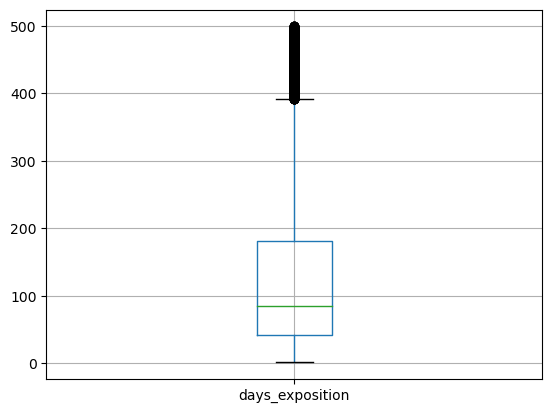

In [118]:
data_good_exp.boxplot(column='days_exposition');

Межквартильный интервал тоже опустился с 500 до почти 400 дней!

**4.15 Задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта?"**

Найдем коээффициент корреляции между стоимостью объекта и несколькими параметрами:

In [119]:
print('Коэффициент корреляции между стоимостью объекта и общей площадью', round(data['last_price'].corr(data['total_area']),2))
print('Коэффициент корреляции между стоимостью объекта и жилой площадью', round(data['last_price'].corr(data['living_area']),2))
print('Коэффициент корреляции между стоимостью объекта и площадью кухни', round(data['last_price'].corr(data['kitchen_area']),2))
print('Коэффициент корреляции между стоимостью объекта и количеством комнат', round(data['last_price'].corr(data['rooms']),2))

Коэффициент корреляции между стоимостью объекта и общей площадью 0.65
Коэффициент корреляции между стоимостью объекта и жилой площадью 0.57
Коэффициент корреляции между стоимостью объекта и площадью кухни 0.52
Коэффициент корреляции между стоимостью объекта и количеством комнат 0.36


Заметной корреляции между стоимостью жилья и каким-бы то ни было из этих 4 параметров не зафиксировано.

Для наглядности покажем диаграмму рассеяния для пары с наибольшим значеним коэффициента корреляции:

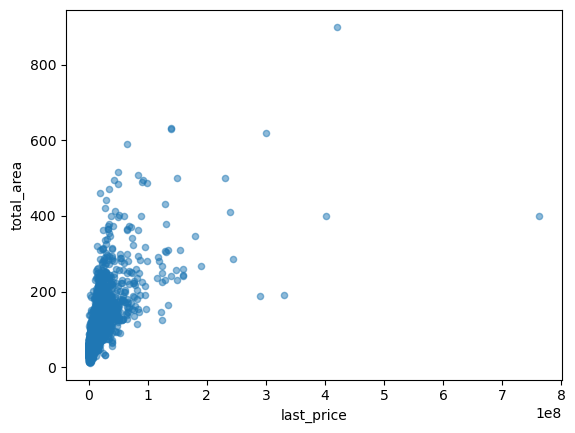

In [120]:
data.plot(x='last_price', y='total_area', kind='scatter', alpha=0.5);

**4.15.1 Посмотрим зависимость стоимости жилья от этажа, на котором расположена квартира (первый, последний, другой):**

,mean,count,median
floor_category,,,
другой,6.675118e+06,17319,4846000.0
последний,7.323296e+06,3328,4300000.0
первый,4.801324e+06,2910,3900000.0


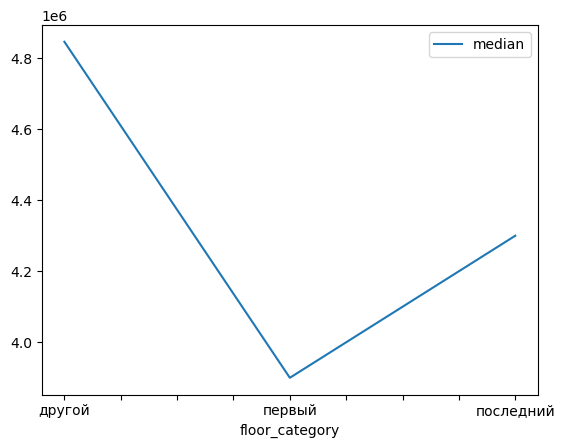

In [121]:
pivot_table_floor_category = data.pivot_table(index = 'floor_category', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_floor_category.columns = ['mean', 'count', 'median']
pivot_table_floor_category.plot(y = 'median')

pivot_table_floor_category.sort_values('median', ascending = False)

Вполне ожидаемые результаты. Самое дешевое жилье на 1 этаже, затем на последнем. На промежуточных этажах цена на жилье выше по сравнению с крайними

**4.15.2 Посмотрим зависимость стоимости жилья от дня недели выставленного объявления:**

,mean,count,median
weekday_exposition,,,
1,6.394582e+06,4173,4720000.0
2,6.624708e+06,3963,4700000.0
0,6.480993e+06,3604,4650000.0
3,6.711767e+06,4286,4650000.0
4,6.366233e+06,3989,4575000.0
5,6.983381e+06,1932,4567500.0
6,6.249360e+06,1692,4550000.0


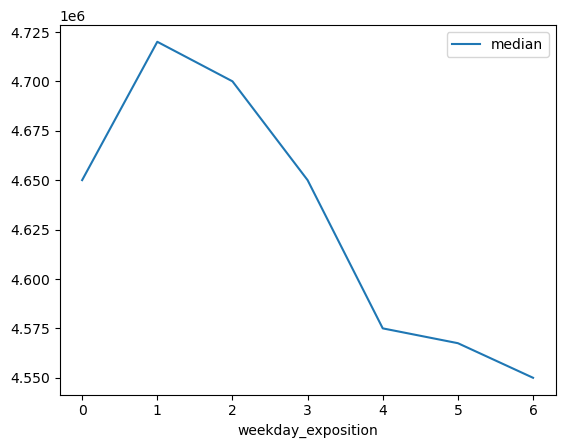

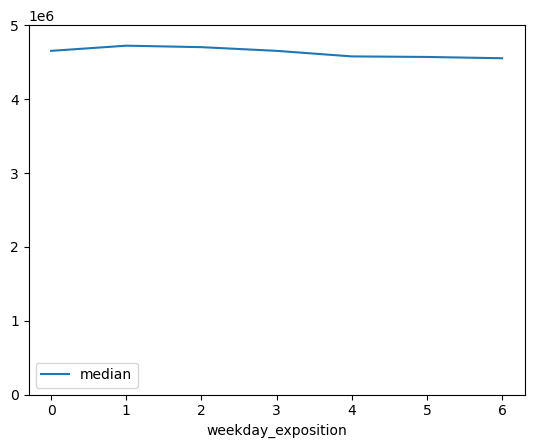

In [122]:
pivot_table_weekday_exposition = data.pivot_table(index = 'weekday_exposition', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_weekday_exposition.columns = ['mean', 'count', 'median']
pivot_table_weekday_exposition.plot(y = 'median')
pivot_table_weekday_exposition.plot(y = 'median', ylim=(0, 5000000))

pivot_table_weekday_exposition.sort_values('median', ascending = False)

На верхнем графике кажется, что разница есть. Но этот обман зрения из-за масштаба. На втором графике этот эффект нивелируется.

Разница между максимальным и минимальным значениями около 3%. Поэтому говорить о какой-то зависимости нет причин.

**4.15.3 Посмотрим зависимость стоимости жилья от месяца выставленного объявления:**

,mean,count,median
month_exposition,,,
4,6.742671e+06,2373,4800000.0
9,6.829244e+06,1978,4700000.0
11,6.461822e+06,2366,4700000.0
12,7.005343e+06,1638,4695000.0
2,6.464463e+06,2639,4650000.0
3,6.364842e+06,2581,4650000.0
7,6.569821e+06,1688,4650000.0
1,6.666975e+06,1491,4600000.0
8,6.356032e+06,1740,4570000.0


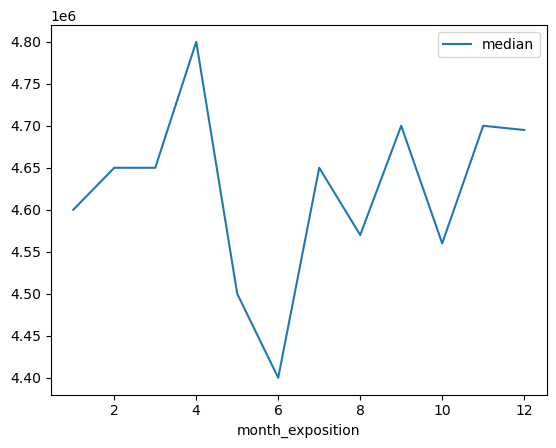

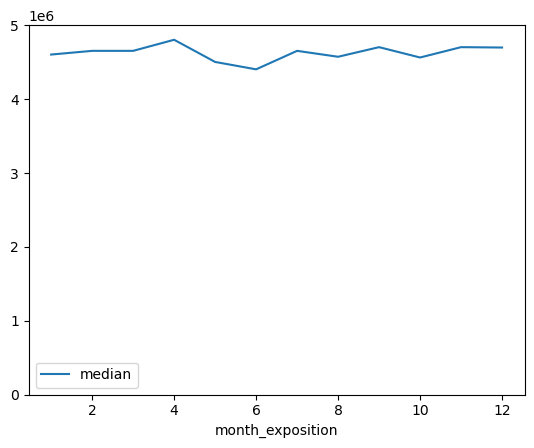

In [123]:
pivot_table_weekday_exposition = data.pivot_table(index = 'month_exposition', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_weekday_exposition.columns = ['mean', 'count', 'median']
pivot_table_weekday_exposition.plot(y = 'median')
pivot_table_weekday_exposition.plot(y = 'median', ylim=(0, 5000000))

pivot_table_weekday_exposition.sort_values('median', ascending = False)

Здесь тоже разница не более 10%. Возможно, что в период апрель-июнь интерес к продаже жилья падает. Видимо, у людей много других забот: отпуска, огороды .... )

**4.15.4 Посмотрим зависимость стоимости жилья от года выставленного объявления:**

,mean,count,median
year_exposition,,,
2014,1.204660e+07,136,7640000.0
2015,8.595494e+06,1172,5337000.0
2019,6.782388e+06,2879,5050000.0
2018,5.951759e+06,8507,4550000.0
2016,6.829860e+06,2764,4540000.0
2017,6.573164e+06,8181,4500000.0


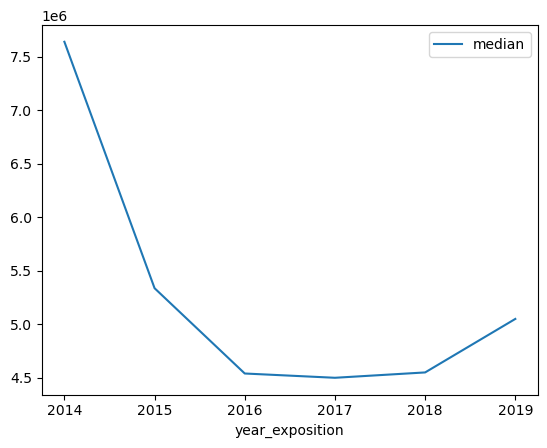

In [124]:
pivot_table_weekday_exposition = data.pivot_table(index = 'year_exposition', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_weekday_exposition.columns = ['mean', 'count', 'median']
pivot_table_weekday_exposition.plot(y = 'median')

pivot_table_weekday_exposition.sort_values('median', ascending = False)

На этом графике заметно снижение активности по продажам жилья после 2014 года. Видимо, сказывается снижение общей финансовой определенности в стране. Люди придерживают продажу недвижимости как существенный актив на более трудные для себя времена.

**4.16 Задание: "Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений"**

In [125]:
locality_pivot_table = data.pivot_table(index = 'locality_name', values = 'last_price', aggfunc=['count', 'mean'])
locality_pivot_table.columns = ['count', 'mean']
locality_pivot_table = locality_pivot_table.sort_values('count', ascending = False).head(10)
locality_pivot_table
#самая высокая стоимость
#locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].max()]
#самая низкая стоимость
#locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].min()]

,count,mean
locality_name,,
Санкт-Петербург,15713,8.056032e+06
посёлок Мурино,556,3.652361e+06
деревня Кудрово,472,4.358688e+06
посёлок Шушары,440,4.108082e+06
Всеволожск,398,3.789068e+06
Пушкин,369,6.469036e+06
Колпино,338,3.964021e+06
посёлок Парголово,327,4.488075e+06
Гатчина,307,3.488337e+06


Из 10 населённых пунктов с самым большим количеством объявлений, самая высокая стоимость жилья в Санкт-Петербурге, тогда как самая низкая - в Выборге.

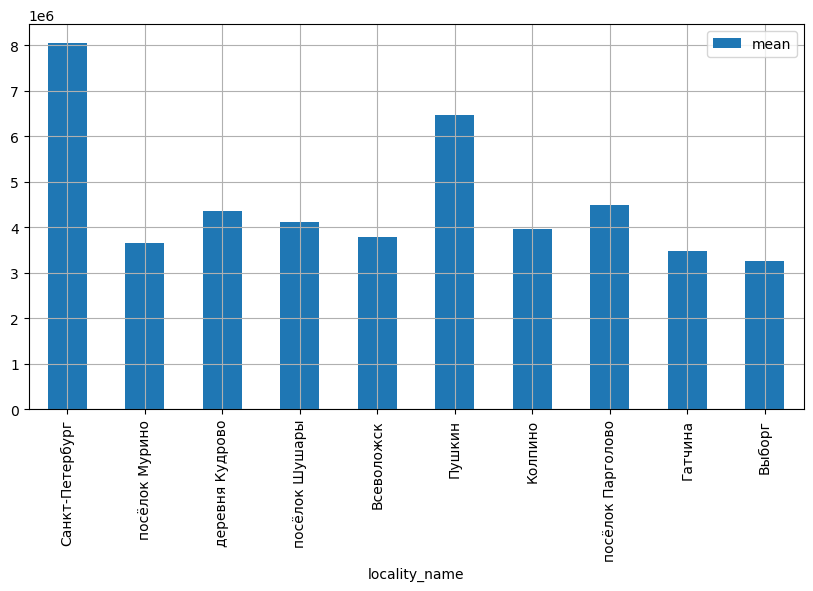

In [126]:
locality_pivot_table.plot(y='mean', kind='bar', figsize=(10, 5), grid=True);

**4.17 Задание: "Выделим квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислим среднюю цену каждого километра"**

,last_price
cityCenter_dist_km,
1.0,1.885085e+07
2.0,1.616331e+07
3.0,1.343683e+07
4.0,1.363202e+07
5.0,1.517110e+07
6.0,1.438911e+07
7.0,1.279767e+07
8.0,8.435474e+06
9.0,6.426055e+06


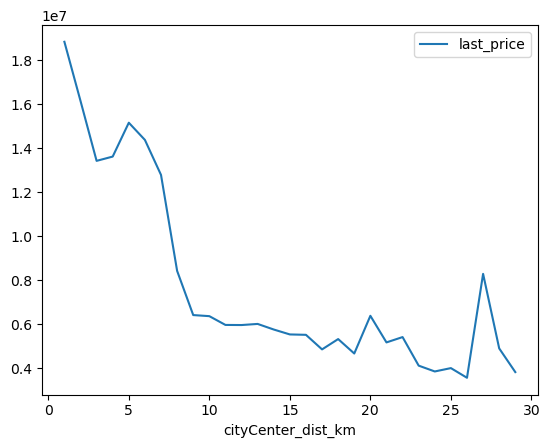

In [127]:
data['cityCenter_dist_km'].fillna(0)
#data['cityCenter_dist_km'] = data['cityCenter_dist_km'].astype('int')
pivot_table_km = data.query('locality_name == "Санкт-Петербург" and \
    cityCenter_dist_km > 0').pivot_table(index = 'cityCenter_dist_km', \
    values = 'last_price', aggfunc = 'mean')
pivot_table_km.plot()
pivot_table_km
#data

По видимому, Санкт-Петербург простирается километров на 30 от центра. Стоимость жилья, естетственно, падает с удаленностью от центра. 
Можно выделить зону с максимальной ценой на удалении примерно 3 км от центра.

### 5 Общий вывод

Type Markdown and LaTeX:  𝛼²

**По результатам исследования можно отметить следующие интересные факты и сделать следующие выводы:**

1.	Для проведения исследования получены данные по размещённым в Санкт-Петербурге объявлениям по продаже жилья с 2014 по 2019 год.
2.	Массив данных записан в файле *real_estate_data.csv*.
3.	Установлено, что значения в файле разделены символом табуляция.
4.	Найдено, что в файле хранятся данные в количестве 23 699 строк на 22 столбца.
5.	Проверены названия столбцов. Все они не имеют ошибочных символов и отвечают стилю *snake*.
6.	Дублирующих строк нет.
7.	8 столбцов из 22 заполнены полностью. Остальные 14 имеют пропущенные значения.
8.	Построены гистограммы по 17 столбцам с количественными значениями. 13 из них имеют не дискретные, а непрерывные значения, на первый взгляд подчиняющихся нормальному закону распределения.
9.	Оценка пропущенных значений и их устранение по возможности:
    - В параметры апартаменты типа boolean пропущенные значения заменены на False.
    - Пропущенная информация по количеству балконов заменена на 0.
10.	Дата публикации объявления приведена к формату Год-Месяц-День.
11.	Удалены дубликаты в названиях населённых пунктов в количестве 41 шт. В основным дублировались слова “пос**е**лок” и “пос**ё**лок”.
12.	Отсутствующая информация о высоте потолка заменена на стандартное значение в 2.7 м, подтверждённое близкими средним и медианным значениями.
13.	Обнаружены опечатки в размере потолков размерами 20-60 метров. Они были уменьшены в 10 раз.
14.	Проведена проверка на присутствие аномальных значений в других столбцах.
15.	Добавили в таблицу следующие столбцы:
    - со стоимостью одного квадратного метра.
    - с днём недели публикации объявления (0 — понедельник, 1 — вторник и так далее),
    - значением месяца публикации объявления,
    - годом публикации объявления,
    - типа этажа квартиры (значения — «первый», «последний», «другой»)
    - расстоянием до центра города в километрах (пересчитаем из метров в километры)
16.	Установлено, что что для продажи выставлено жильё с большим диапазоном по размеру общей площади. Размах составляет от 12 м² (возможно 1 комната или мини студия) до огромных 900 м² с 12 комнатами! Медианное значение на рынке составляет около 52 м². Наблюдается хорошая корреляция (к = 0.94) между значениями жилой площади и общей площади. Интересно, что на продажу были выставлены уникальные и сверхдорогие квартиры дороже 200 млн рублей. Их около десятка. Все они представлены в единичном экземпляре
17.	Отметили три ярко выраженных пика значения жилой площади на уровне 18, 30 и 45 м². Такому поведению графика есть простое объяснение, так как это наиболее характерные значения размеров жилой площади для 1, 2 и 3-х комнатных квартир соответственно. Таких квартир много в старом жилом фонде. Но на рынке есть и редкие квартиры большой площади. Около 10 продаваемых квартир имеет площадь 500 - 630 м². Но самых уникальным является предложение № 19540 с квартирой в 900 м².
18. В продаже были уникальные предложения с квартирами по 11, 12, 14, 15, 16 и 19 комнат! Их количество - около десятка.
19.	Обратили внимание на то, что на рынке появляются предложения на жилье с площадью кухни менее 3 м². Практически все они "малоёмкие" с общей площадью в 20-30 м². Такие квартиры строили в 60-х годах прошлого века.
20.	Медианное значение стоимости выставленного на продажу жилья соответствует 4,5 млн рублей за квартиру. Минимальное значение около 1.2 тыс рублей (видимо доля в квартире или комната) до 760 млн рублей за огромную современную квартиру.
21.	Появляются предложения на квартиры в доме высотой в 60 этажей!
22.	Кроме самого Санкт-Петербурга, популярны предложения из ближайших пригородов, Петергоф, Пушкин, Колпино и др.
23.	Жилые массивы находятся на расстоянии 10-60 км от ближайшего аэропорта.
24.	В Санкт-Петербурге и пригородах много парков. В основном жилые дома находятся не дальше 1 км от ближайшего парка.
25.	Количество продаж традиционно падает в период апрель-июнь. Люди занимаются отпуском и проводят время на дачах и огородах.
26.	Среднее время продажи квартир – полгода.
27.	Найдена интересная закономерность, не нашедшая объяснения. Публикации о продаже массово снимаются на 7, 30, 45, 60 и 90 день их публикации!
28.	Первый и последний этажи дешевле.
29.	Отмечено снижение активности продаж жилья после 2014 года. Видимо, сказывается снижение общей финансовой определённости в стране. Люди придерживают продажу недвижимости как существенный актив на более трудные для себя времена.
30.	Из 10 населённых пунктов с самым большим количеством объявлений, самая высокая стоимость жилья в Санкт-Петербурге, тогда как самая низкая - в Выборге.
31.	Стоимость жилья, естественно, падает с удалённостью от центра. Можно выделить зону с максимальной ценой на удалении примерно 3 км от центра.

Таким образом, можно констатировать, что Санкт-Петербург имеет ресурсы в области жилья. В зависимости от финансовой возможности, можно подобрать любой вариант.

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [X]  есть пояснение, какие пропущенные значения обнаружены
- [X]  изменены типы данных
- [X]  есть пояснение, в каких столбцах изменены типы и почему
- [X]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [X]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [X]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [X]  посчитано и добавлено в таблицу: месяц публикации объявления
- [X]  посчитано и добавлено в таблицу: год публикации объявления
- [X]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [X]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [X]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x] выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод

[Вернутся к общему списку проектов курса “Data Science” Яндекс-практикума](../README.md)